In [1]:
import torch
import pytorch_lightning as pl

from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  


In [2]:
import bliss

from bliss.datasets.simulated import SimulatedDataset
import bliss.models.encoder as encoder_lib
from bliss.models.decoder import ImageDecoder
from bliss import sleep

from bliss import device, use_cuda
print(device)
print(use_cuda)

data_path = Path('../data/')

cuda
True


In [3]:
# torch.manual_seed(2342)
# np.random.seed(354)

# Model parameters

In [4]:
# create training dataset
n_bands = 2
slen = 16

tile_slen = 4

In [5]:
# set background
background = torch.zeros(n_bands, slen, slen, device=device)
background[:] = 686.0

In [6]:
# psf parameters 
psf_file = data_path.joinpath("fitted_powerlaw_psf_params.npy")
psf_params = torch.from_numpy(np.load(psf_file)).to(device)

In [7]:
# None referes to no galaxies
prob_galaxy = 0.
dec_args = (None, psf_params, background)

decoder_kwargs = dict(n_bands=n_bands,
                        slen=slen,
                        tile_slen=tile_slen,
                        prob_galaxy=prob_galaxy,
                        max_sources_per_tile=4,
                        mean_sources_per_tile=0.8,
                        min_sources_per_tile=0,
                        f_min=1e4,
                        f_max=1e6,
                        alpha=0.5,
                        add_noise=True)

# Define dataset

In [8]:
n_batches = 20
batchsize = 2048
dataset = SimulatedDataset(n_batches, batchsize, dec_args, decoder_kwargs)

### a few example images

In [9]:
data_sampled = dataset.get_batch()
images = data_sampled['images']

n_sources_full, locs_full = \
    encoder_lib._get_full_params_from_sampled_params(
                                                    slen,
                                                    tile_slen,
                                                    data_sampled['n_sources'],
                                                    data_sampled['locs'])

In [10]:
%matplotlib inline  

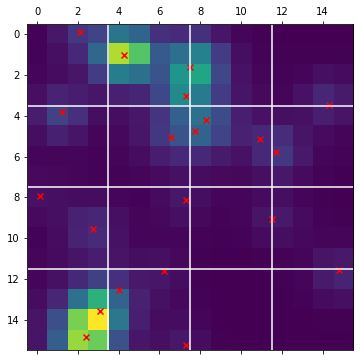

In [11]:
f, axarr = plt.subplots(1, 1, figsize=(6, 6))

batch = int(np.random.choice(batchsize))
band = 0

# plot image
axarr.matshow(images[batch, band].cpu().detach())

# plot locations 
n = int(n_sources_full[batch])
axarr.scatter(locs_full[batch, 0:n, 1].cpu() * slen - 0.5, 
              locs_full[batch, 0:n, 0].cpu() * slen - 0.5, 
              color = 'red', marker = 'x')

for i in range(int(slen / tile_slen)): 
    axarr.axvline(tile_slen * i - 0.5, color = 'white')
    axarr.axhline(tile_slen * i - 0.5, color = 'white')
    

# Define encoder 

In [12]:
edge_padding = 2
ptile_slen = tile_slen + 2 * edge_padding
encoder_kwargs = dict(slen=slen,
                        ptile_slen=ptile_slen,
                        tile_slen=tile_slen,
                        n_bands=n_bands,
                        max_detections=dataset.image_decoder.max_sources_per_tile,
                        n_galaxy_params=8,
                        enc_conv_c=20,
                        enc_kern=3,
                        enc_hidden=256,
                        momentum=0.5)

In [13]:
sleep_net = sleep.SleepPhase(dataset, encoder_kwargs)
sleep_net.to(device);

In [14]:
sleep_net.get_loss(dataset.get_batch())

(tensor(102.2892, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor([2.5489, 1.7452, 2.6134,  ..., 1.3057, 0.7199, 1.6131], device='cuda:0',
        grad_fn=<NegBackward>),
 tensor([5.4774, -0.0000, 5.7609,  ..., -0.0000, -0.0000, -0.0000],
        device='cuda:0', grad_fn=<MinBackward0>),
 tensor([-0., -0., -0.,  ..., -0., -0., -0.], device='cuda:0',
        grad_fn=<NegBackward>),
 tensor([372.0963,  -0.0000, 376.4698,  ...,  -0.0000,  -0.0000,  -0.0000],
        device='cuda:0', grad_fn=<NegBackward>),
 tensor([1.6518, -0.0000, 1.6402,  ..., -0.0000, -0.0000, -0.0000],
        device='cuda:0', grad_fn=<NegBackward>))

# Train!

In [15]:
n_epochs = 40

In [16]:
sleep_trainer = pl.Trainer(
            gpus = 1,
            min_epochs=n_epochs,
            max_epochs=n_epochs,
            reload_dataloaders_every_epoch=True,
            logger=False,
            checkpoint_callback=False,
        )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [17]:
sleep_trainer.fit(sleep_net)


  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 537 K 
/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1: : 18it [00:03,  5.21it/s, loss=31.581]

/home/runingli/anaconda3/envs/celeste_py/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


Epoch 1: : 18it [00:03,  5.21it/s, loss=31.581]


1

# Check on test data

In [18]:
test_data = dataset.get_batch()

In [19]:
test_image = test_data['images'][0:1]

true_n_sources_full, true_locs_full = \
    encoder_lib._get_full_params_from_sampled_params(
                                                    slen,
                                                    tile_slen,
                                                    test_data['n_sources'],
                                                    test_data['locs'])

In [20]:
test_image.shape

torch.Size([1, 2, 16, 16])

In [21]:
sleep_net.image_encoder.eval();

In [22]:
n_sources, est_locs, est_galaxy_params, est_log_fluxes, est_galaxy_bool = \
    sleep_net.image_encoder.map_estimate(test_image)

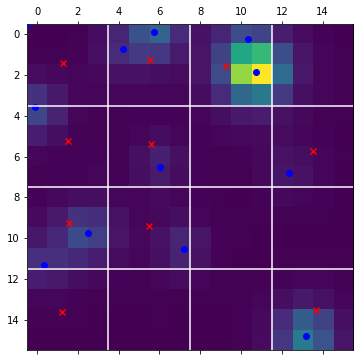

In [23]:
f, axarr = plt.subplots(1, 1, figsize=(6, 6))

band = 0

# plot image
axarr.matshow(test_image[0, band].cpu().detach())

# plot true locations 
axarr.scatter(true_locs_full[0, :, 1].detach().cpu() * slen - 0.5, 
              true_locs_full[0, :, 0].detach().cpu() * slen - 0.5, 
              color = 'blue', marker = 'o')

# plot estimated locations 
n = int(n_sources[0])
axarr.scatter(est_locs[0, 0:n, 1].detach().cpu() * slen - 0.5, 
              est_locs[0, 0:n, 0].detach().cpu() * slen - 0.5, 
              color = 'red', marker = 'x')

for i in range(int(slen / tile_slen)): 
    axarr.axvline(tile_slen * i - 0.5, color = 'white')
    axarr.axhline(tile_slen * i - 0.5, color = 'white')
    